In [1]:
#! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col].fillna('NA', inplace=True)
        else:
            df[col].fillna(0.0, inplace=True)

/tmp/ipykernel_1617/1904742649.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('NA', inplace=True)
/tmp/ipykernel_1617/1904742649.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.meth

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values
print(len(df_train), len(df_val), len(df_test))

876 293 293


In [6]:
# Cell 5 — Compute AUCs for numerical features
num_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

for v in num_vars:
    auc = roc_auc_score(y_train, df_train[v])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[v])
    print(f"{v}: {auc:.3f}")


lead_score: 0.614
number_of_courses_viewed: 0.764
interaction_count: 0.738
annual_income: 0.552


In [7]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"Validation AUC: {auc:.3f}")

Validation AUC: 0.877


In [9]:
thresholds = np.linspace(0, 1, 101)
precisions, recalls = [], []

for t in thresholds:
    y_pred_t = (y_pred >= t)
    precisions.append(precision_score(y_val, y_pred_t))
    recalls.append(recall_score(y_val, y_pred_t))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


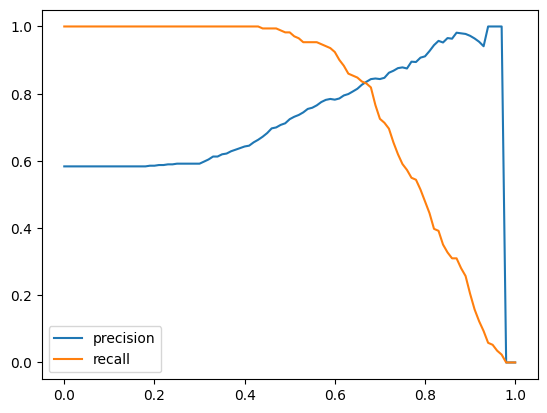

In [10]:
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.legend()
plt.show()

In [11]:
diff = np.abs(np.array(precisions) - np.array(recalls))
best_t = thresholds[np.argmin(diff)]
print(f"Precision and Recall intersect at: {best_t:.3f}")

Precision and Recall intersect at: 0.980


In [12]:
f1_scores = []
for p, r in zip(precisions, recalls):
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
    f1_scores.append(f1)
best_t_f1 = thresholds[np.argmax(f1_scores)]
print(f"Max F1 at threshold: {best_t_f1:.2f}") 

Max F1 at threshold: 0.58


In [13]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    train_dicts = df_train.to_dict(orient='records')
    val_dicts = df_val.to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("AUCs:", np.round(scores, 3))
print("Mean:", round(np.mean(scores), 3))
print("Std:", round(np.std(scores), 3)) 


AUCs: [0.869 0.922 0.843 0.842 0.903]
Mean: 0.876
Std: 0.032


In [14]:
C_values = [0.000001, 0.001, 1]
for C in C_values:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        train_dicts = df_train.to_dict(orient='records')
        val_dicts = df_val.to_dict(orient='records')

        X_train = dv.fit_transform(train_dicts)
        X_val = dv.transform(val_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f"C={C} -> Mean: {np.mean(scores):.3f}, Std: {np.std(scores):.3f}")


C=1e-06 -> Mean: 0.561, Std: 0.024
C=0.001 -> Mean: 0.926, Std: 0.018
C=1 -> Mean: 0.876, Std: 0.032
